In [2]:
import networkx as nx
from scipy.optimize import curve_fit
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import osmnx as ox
from sklearn.cluster import KMeans
from sklearn import metrics
from itertools import cycle
import matplotlib.cm as cm
from shapely import geometry
from scipy.spatial import ConvexHull
from sklearn.metrics import mean_squared_error
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import geometry, ops
from scipy.spatial import Voronoi, voronoi_plot_2d
import random
import plotly.graph_objects as go
from tqdm import tqdm



def bbox_maker(lat0, lat1, long0,long1):
    return Polygon([[long0, lat0],
                    [long1,lat0],
                    [long1,lat1],
                    [long0, lat1]])

def get_rsq(f, x, y, popt):

    ss_res = np.dot((y - f(x, *popt)),(y - f(x, *popt)))
    ymean = np.mean(y)
    ss_tot = np.dot((y-ymean),(y-ymean))
    return 1-ss_res/ss_tot

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def func2(x, a, b):
    return a * x + b

def get_Graph(city):
    nodes, edges = pd.read_csv(f"./Results/csv/{city}_nodes.csv", index_col =[0]), pd.read_csv(f"./Results/csv/{city}_edges.csv", index_col = [0,1,2], encoding = 'latin-1')
    edges["highway"] = edges.highway.map(lambda x: x[0] if isinstance(x, list) else x)
    edges = edges[~edges["Cost of return"].isna()]
    others = ["crossing", "living_street", "unclassified", "disused", "busway", "escape", "road", "ladder"]
    edges["highway"] = edges.highway.map(lambda x: "other" if x  in others else x)
    # edges["Cost of return"] = edges["Cost of return"]fillna(0)
    s = gpd.GeoSeries.from_wkt(nodes.geometry)
    nodes = gpd.GeoDataFrame(data = nodes, geometry = s)
    nodes = nodes.set_crs('epsg:4326', allow_override=True)
    s = gpd.GeoSeries.from_wkt(edges.geometry)
    edges = gpd.GeoDataFrame(data = edges, geometry = s)
    edges = edges.set_crs('epsg:4326', allow_override=True)

    G = ox.graph_from_gdfs(nodes, edges)
    H = nx.MultiDiGraph()
    H.add_nodes_from(sorted(G.nodes(data=True)))
    H.add_edges_from(G.edges(data=True))
    H.graph["crs"] = G.graph["crs"]
    return H, nodes, edges

def Voronoi_polys(bbox_bounds, centers, plot = False, G = None):
    bound = geometry.box(*bbox_bounds).buffer(0.1).envelope.boundary
    boundarypoints = [bound.interpolate(distance=d) for d in np.arange(0, np.ceil(bound.length).astype(float), 0.01)]
    boundarycoords = np.array([[p.x, p.y] for p in boundarypoints])
    all_coords = np.concatenate((boundarycoords, [[i[1],i[0]] for i in centers])) #Create an array of all points on the boundary and inside the polygon
    vor = Voronoi(points=all_coords)
    lines = [geometry.LineString(vor.vertices[line]) for line in 
        vor.ridge_vertices if -1 not in line]

    polys = ops.polygonize(lines)
    voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), crs="epsg:4326")

    polydf = gpd.GeoDataFrame(geometry=[geometry.box(*bbox_bounds)], crs="epsg:4326")
    points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=centers[:,1], y=centers[:,0], crs="epsg:4326"))

    result = gpd.overlay(df1=voronois, df2=polydf, how="intersection")
    if plot and G != None:
        if plot and G == None:
            print("Missing the graph to plot.")
            return result
        fig, ax = plt.subplots(figsize=(15, 15))
        polydf.boundary.plot(ax=ax, edgecolor="blue", linewidth=6)
        ox.plot_graph(G, ax = ax, node_color = 'k', show = False, close = False)
        result.plot(ax=ax, color="red", alpha=0.3, edgecolor="black")
        points.plot(ax=ax, color="maroon")
    return result

font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

In [3]:
city_list_full = ["São Paulo", # 0
                  "Rio de Janeiro", # 1
                  "Atlanta", # 2
                  "Manhattan", # 3
                  "Barcelona", # 4
                  "Madrid", # 5
                  "Buenos Aires", # 6 
                  "London", # 7
                  "Beijing", # 8
                  "Paris", # 9
                  "Cardiff", # 10
                  "Berlin", # 11
                  "Amsterdam", # 12
                  "São José dos Campos", # 13
                  "Los Angeles", # 14
                  "Wichita", # 15
                  "Toulouse", # 16
                  "Salt Lake", # 17
                  ]

categories = ['motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary', 'primary_link', 'secondary', 'secondary_link', 'tertiary', 'tertiary_link', 'residential', 'other']
categories.reverse()

group1 = ['motorway', 'motorway_link', 'trunk', 'trunk_link']
group2 = ['primary', 'primary_link', 'secondary', 'secondary_link', 'tertiary', 'tertiary_link']
group3 = group1 + group2

percents = np.arange(0.01, 0.11, 0.01)
all_wccs_COR_high = pd.DataFrame(index = percents)
all_wccs_SP = pd.DataFrame(index = percents)
all_wccs_random = pd.DataFrame(index = percents)
all_wccs_bet_high = pd.DataFrame(index = percents)

all_nodes_list = []
all_edges_list = []
all_graphs = []
for city in tqdm(city_list_full):
    G, nodes, edges = get_Graph(city)
    # edges["highway"] = edges.highway.map(lambda x: x[0] if isinstance(x, list) else x)

    # edges["Groups"] = edges.highway

    # edges["Groups"] = edges.highway.map(lambda x: 'C' if x  not in group3 else x)
    # edges["Groups"] = edges.Groups.map(lambda x: 'A' if x  in group1 else x)
    # edges["Groups"] = edges.Groups.map(lambda x: 'B' if x  in group2 else x)
    # edges.to_csv(f"Results/csv/{city}_edges.csv")
    
    nodes["City"] = city
    edges["City"] = city

 ## CONNECTED COMPONENTS

    total_wccs = []
    for j in percents:
        topcor = edges.sort_values(by = "Cost of return", ascending = False).head(int(j*len(edges))).index
        H = nx.MultiGraph.copy(G)
        H.remove_edges_from(topcor)
        wccs = []
        for i in nx.weakly_connected_components(H):
            wccs.append(len(i))
        total_wccs.append(max(wccs)/G.number_of_nodes())
    all_wccs_COR_high[city] = total_wccs

    total_wccs = []
    for j in percents:
        topcor = edges.sort_values(by = "Inverse SP", ascending = False).head(int(j*len(edges))).index
        H = nx.MultiGraph.copy(G)
        H.remove_edges_from(topcor)
        wccs = []
        for i in nx.weakly_connected_components(H):
            wccs.append(len(i))
        total_wccs.append(max(wccs)/G.number_of_nodes())
    all_wccs_SP[city] = total_wccs
    
    randoms_wcc = pd.DataFrame(index = percents)
    for k in range(10):
        total_wccs = []
        for j in percents:
            randoms_sample = random.sample(list(edges.index), k = int(j*len(edges)))
            H = nx.MultiGraph.copy(G)
            H.remove_edges_from(randoms_sample)
            wccs = []
            for i in nx.weakly_connected_components(H):
                wccs.append(len(i))
            total_wccs.append(max(wccs)/G.number_of_nodes())
        randoms_wcc[str(k)] = total_wccs
    all_wccs_random[city] = randoms_wcc.T.mean()

    total_wccs = []
    for j in percents:
        highb = edges.sort_values(by = "Edge Betweenness", ascending = False).head(int(j*len(edges))).index
        H = nx.MultiGraph.copy(G)
        H.remove_edges_from(highb)
        wccs = []
        for i in nx.weakly_connected_components(H):
            wccs.append(len(i))
        total_wccs.append(max(wccs)/G.number_of_nodes())
        # print(H.number_of_edges()/G.number_of_edges())
        del(H)
    all_wccs_bet_high[city] = total_wccs

    all_nodes_list.append(nodes)
    all_edges_list.append(edges)
    all_graphs.append(G)


all_dfs_nodes = pd.concat(all_nodes_list)
all_dfs_edges = pd.concat(all_edges_list)

# all_dfs_edges["Groups"] = all_dfs_edges.highway

# all_dfs_edges["Groups"] = all_dfs_edges.Groups.map(lambda x: 'A' if x  in group1 else x)
# all_dfs_edges["Groups"] = all_dfs_edges.Groups.map(lambda x: 'B' if x  in group2 else x)
# all_dfs_edges["Groups"] = all_dfs_edges.Groups.map(lambda x: 'C' if x  not in group3 else x)
del(nodes)
del(edges)
del(all_nodes_list)
del(all_edges_list)


100%|██████████| 18/18 [03:51<00:00, 12.86s/it]


## Classes

In [ ]:
fig = px.box(all_dfs_edges[all_dfs_edges["Cost of return"] != 0], x = "highway", y = "Cost of return")
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.write_image(f"Results/all_together/all_box_classes.pdf")
fig

### Distributions

In [ ]:
fig = px.bar(all_dfs_edges.sort_values(by="Cost of return", ascending=False)["highway"].head(len(all_dfs_edges)//100).value_counts(normalize=True), title = "Top 1% COR distribution")
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.update_yaxes(range=[0,0.6])

fig.update_layout(    font=dict(
        size=25,
        color="black"
    ))
fig.write_image(f"Results/all_together/all_1percent_classes.pdf", width=1000, height=1000)

fig

In [ ]:
fig = px.bar(all_dfs_edges.sort_values(by="Cost of return", ascending=False)["highway"].head(len(all_dfs_edges)//20).value_counts(normalize=True), title = "Top 5% COR distribution")
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.update_yaxes(range=[0,0.6])

fig.update_layout(    font=dict(
        size=25,
        color="black"
    ))
fig.write_image(f"Results/all_together/all_5percent_classes.pdf", width=1000, height=1000)

fig

In [ ]:
fig = px.bar(all_dfs_edges["highway"].value_counts(normalize=True), title = "Representation of each class")
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.update_yaxes(range=[0,0.6])

fig.update_layout(    font=dict(
        size=25,
        color="black"
    ))
fig.write_image(f"Results/all_together/representation_classes.pdf", width=1000, height=1000)

fig

## Groups

In [ ]:
categories = ['C','B','A']
fig = px.box(all_dfs_edges, x = "Groups", y = "Cost of return", title = "All cities", labels = {"Cost of return" : "Cost of return"})
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.update_traces(boxmean=True)
fig.update_layout(    font=dict(
        size=25,
        color="black"),
        showlegend=False
        )
fig.write_image(f"./Results/all_box_groups.pdf", width=1000, height=1000)
fig

### Distributions

In [46]:
fig = px.bar(all_dfs_edges.sort_values(by="Cost of return", ascending=False)["Groups"].head(len(all_dfs_edges)//100).value_counts(normalize=True)*100, title = "Top 1% CoR distribution")
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.update_yaxes(range=[0,70], title = "Percentage")

fig.update_layout(    font=dict(
        size=25,
        color="black"),
        showlegend=False
        )
# fig.write_image(f"Results/all_1percent_classes.pdf", width=500, height=1000)
fig

In [47]:
fig = px.bar(all_dfs_edges.sort_values(by="Cost of return",ascending=False)["Groups"].head(len(all_dfs_edges)//20).value_counts(normalize=True)*100, title = "Top 5% CoR distribution")
fig.update_xaxes(categoryorder='array', categoryarray=categories)
fig.update_yaxes(range=[0,70],  title = "Percentage")
fig.update_layout(    font=dict(
        size=25,
        color="black",),
        showlegend=False
        )
# fig.write_image(f"Results/all_5percent_classes.pdf", width=500, height=1000)

fig

## Clustering

São Paulo 21
Rio de Janeiro 26
Atlanta 153
Atlanta failed
Manhattan 10
Barcelona 52
Madrid 57
Buenos Aires 30
London 177
Beijing 30
Paris 86
Cardiff 58
Berlin 75
Amsterdam 40
São José dos Campos 114
São José dos Campos failed
Los Angeles 21
Wichita 35
Tolouse 55
Salt Lake 73


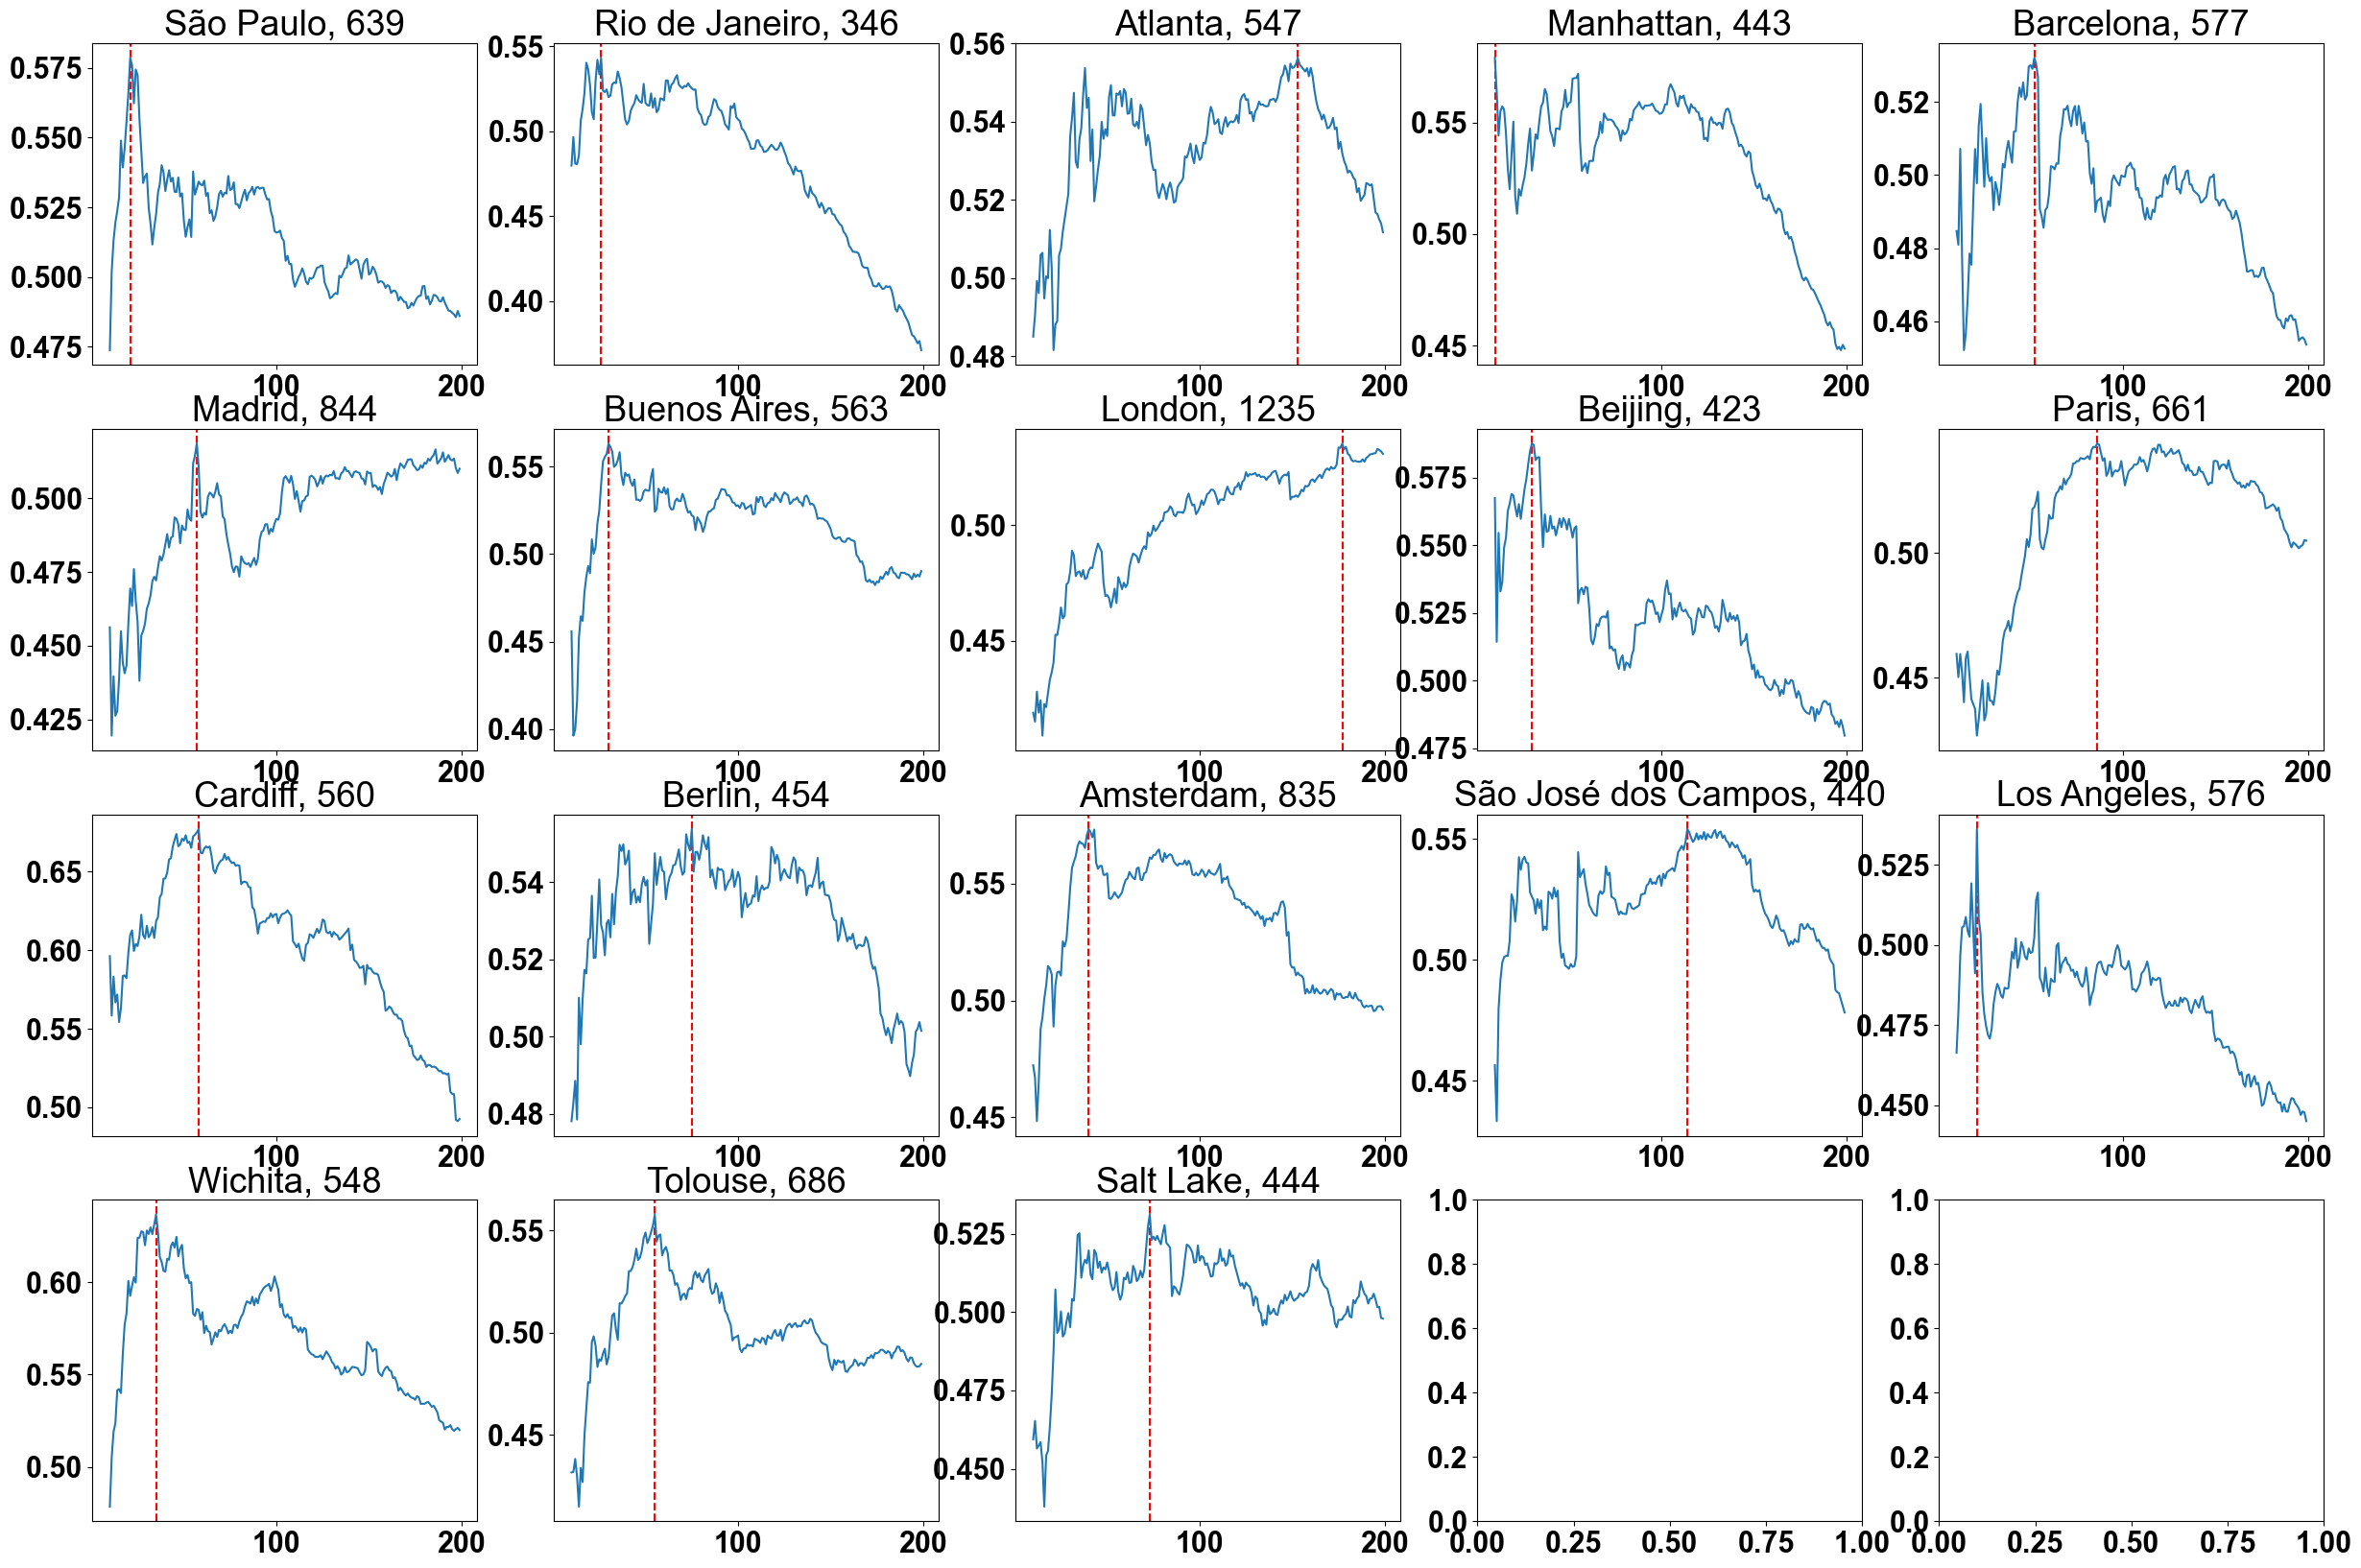

In [ ]:
all_recs = []
all_n_strong_connected = []
all_mreg_COR = []
all_sreg_COR = []
cities = []
ccount = []
fig, axs = plt.subplots(4, 5, figsize=(30,20))
min_clusters = 10
for city, ax in zip(city_list_full, axs.flatten()):
    edges = all_dfs_edges[all_dfs_edges["City"] == city]
    nodes = all_dfs_nodes[all_dfs_nodes["City"] == city]
    # qtd = sum(edges.highway == "residential")//20
    qtd = len(edges)//20
    max_clusters = 200
    x_points = range(qtd)
    lpoint = []
    xs, ys = [], []
    for i in x_points:
        # point = edges[edges.highway == "residential"].sort_values(by = "Cost of return", ascending=False).iloc[i].geometry.centroid
        point = edges.sort_values(by = "Cost of return", ascending=False).iloc[i].geometry.centroid
        lpoint.append([point.y, point.x])
    lpoint = np.array(lpoint)
    silhouette_avg = []

    for clusters in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=clusters, random_state=10, n_init="auto").fit(lpoint)
        silhouette_avg.append(metrics.silhouette_score(lpoint, kmeans.labels_))

    sils = dict(zip(range(min_clusters, max_clusters), silhouette_avg))
    n_clusters = max(sils, key=sils.get)
    print(city, n_clusters)

    ccount.append(n_clusters)
    ax.axvline(n_clusters, color="r", linestyle="--")
    ax.plot(range(min_clusters, max_clusters), silhouette_avg)
    ax.set_title(f"{city}, {qtd}")

    recs = []
    n_strong_connected = []
    mean_reg_COR = []
    sum_reg_COR = []
    kmeans = KMeans(n_clusters=n_clusters, random_state=10, n_init="auto").fit(lpoint)
    centers = kmeans.cluster_centers_
    polylist = Voronoi_polys(bbox_bounds=nodes.total_bounds, centers = centers).geometry
    for i in range(n_clusters):
        # plot one cluster for each iteration
        # find indeces corresponding to cluser i
        idx = kmeans.labels_ == i

        # for index in hull.vertices: #Indices of points forming the vertices of the convex hull.
        #     polylist.append(points_united[index]) #Append this index point to list

        p = polylist[i]
        try:
            K = ox.graph_from_polygon(p, "drive", truncate_by_edge=True)
            n_strong_connected.append([len(c) for c in sorted(nx.strongly_connected_components(K), key=len, reverse=True)])
            x,y = p.exterior.xy
            clipping = gpd.clip(edges, mask = p)["Cost of return"]
            mean_reg_COR.append(clipping.mean())
            sum_reg_COR.append(clipping.sum())
            count_scc=[len(i) for i in n_strong_connected]
            recs.append(nx.reciprocity(K))
        except:
            print(f"{city} failed")
    all_mreg_COR.append(mean_reg_COR)
    all_sreg_COR.append(sum_reg_COR)
    all_recs.append(recs)
    all_n_strong_connected.append(count_scc)
    cities.append(city)

fig.savefig("Results/all_silhouette.png", bbox_inches='tight')


0.17208326607722726 1.9197718305479372e-47 0.09423975595842086


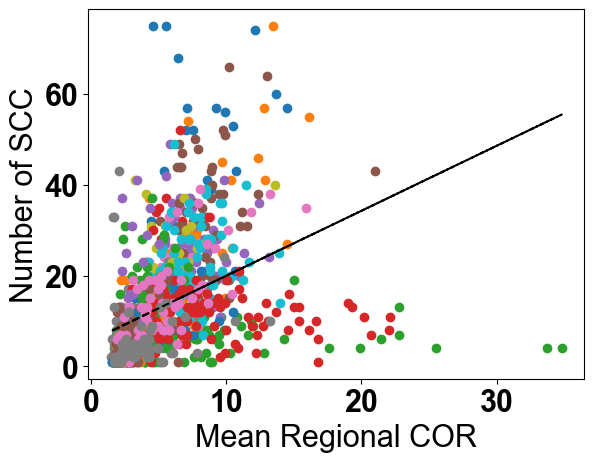

In [ ]:
plt.figure()
plt.ylabel("Number of SCC")
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.hstack(all_mreg_COR),np.hstack(all_n_strong_connected))
poly1d_fn = np.poly1d([slope, intercept])
print(r_value**2, p_value, std_err)
plt.xlabel("Mean Regional COR")
# plt.legend(city_list_full)
# plt.plot(all_mreg_COR, all_n_strong_connected, 'o', all_mreg_COR, poly1d_fn(all_mreg_COR), '--k')
for x,y in zip(all_mreg_COR, all_n_strong_connected):
    plt.plot(x, y, 'o')
plt.plot(np.hstack(all_mreg_COR), poly1d_fn(np.hstack(all_mreg_COR)), '--k')

plt.show()

0.5020157650983109 4.311990188517239e-170 0.00024978089541607143 0.008351718966934298 4.915770401372109


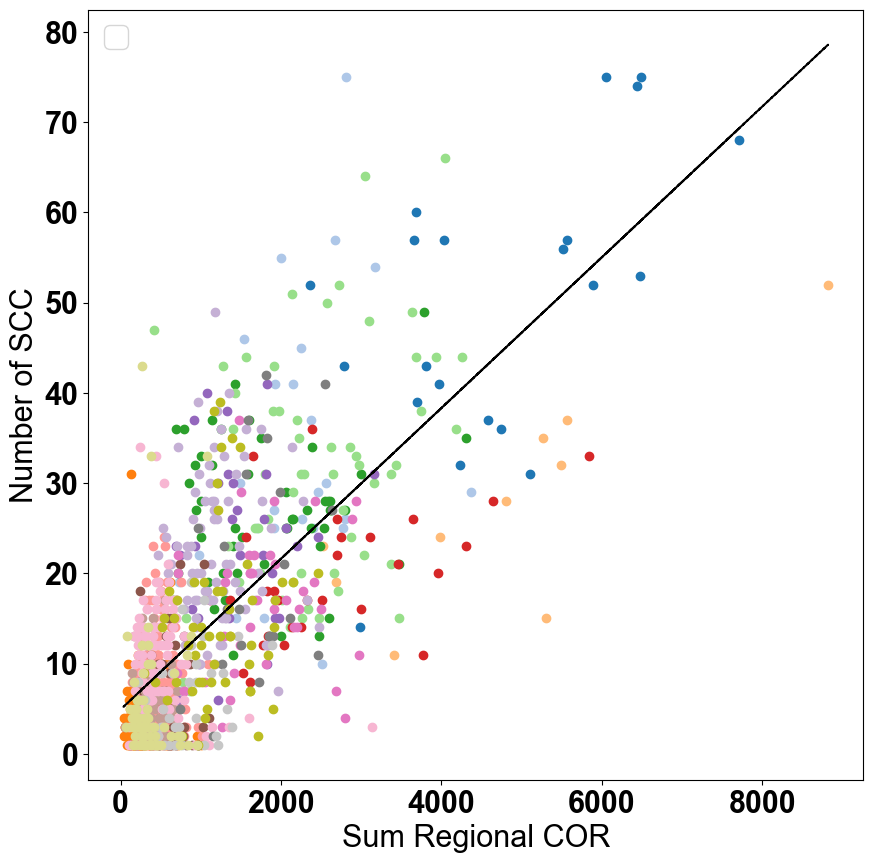

In [ ]:
plt.figure(figsize=(10,10))
colors = cycle(cm.tab20.colors)

plt.ylabel("Number of SCC")
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.hstack(all_sreg_COR),np.hstack(all_n_strong_connected))
poly1d_fn = np.poly1d([slope, intercept])
print(r_value**2, p_value, std_err, slope, intercept)
plt.xlabel("Sum Regional COR")
plt.legend(city_list_full)
# plt.plot(all_mreg_COR, all_n_strong_connected, 'o', all_mreg_COR, poly1d_fn(all_mreg_COR), '--k')
for x,y in zip(all_sreg_COR, all_n_strong_connected):
    color = next(colors)
    plt.plot(x, y, 'o', c = color)
plt.plot(np.hstack(all_sreg_COR), poly1d_fn(np.hstack(all_sreg_COR)), '--k')
# plt.legend(labels = city_list_full)
plt.savefig("Results/all_together/all_SCC.pdf", bbox_inches = "tight")

plt.show()

0.17208326607722757 [1.43079006 5.65976411]


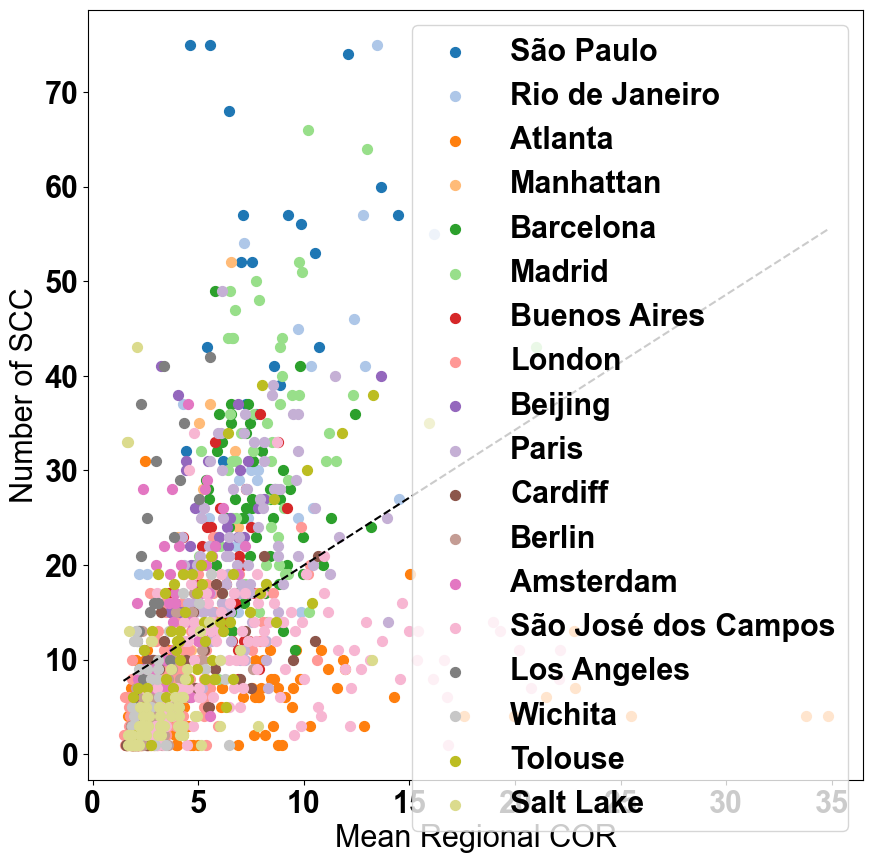

In [ ]:
plt.figure(figsize=(10,10))
plt.ylabel("Number of SCC")
popt, pcov = curve_fit(func2, np.hstack(all_mreg_COR), np.hstack(all_n_strong_connected), maxfev = 3000)
print(get_rsq(func2, np.hstack(all_mreg_COR), np.hstack(all_n_strong_connected), popt), popt)
xdata = np.sort(np.hstack(all_mreg_COR))
ydata =  func2(xdata, *popt)
# print(r_value**2, p_value, std_err)
plt.xlabel("Mean Regional COR")

colors = cycle(cm.tab20.colors)
for i in range(len(city_list_full)):
    # plot one cluster for each iteration
    color = next(colors)
    # find indeces corresponding to cluser i
    # idx = kmeans.labels_ == i
    # plot cluster
    plt.scatter(all_mreg_COR[i], all_n_strong_connected[i], color=color, s=50, label=i, alpha=1)
    # plot center

plt.legend(labels = city_list_full)
plt.plot(xdata, ydata, 'k--')
plt.savefig("Results/all_together/all_SCC.pdf", bbox_inches = "tight")
plt.show()

In [ ]:
# colors = cycle(cm.tab20.colors)

# plt.figure(figsize=(20,15))
# for i in range(len(city_list_full)):
#     plt.subplot(3,4,i+1)
#     # plot one cluster for each iteration
#     color = next(colors)
#     # find indeces corresponding to cluser i
#     # idx = kmeans.labels_ == i
#     # plot cluster
#     plt.title(city_list_full[i])
#     plt.scatter(all_mreg_COR[i], all_n_strong_connected[i], color=color, s=50, label=i, alpha=1)
#     # plot center
# colors = cycle(cm.tab20.colors)

# for i in range(len(city_list_full)):
#     plt.subplot(3,4,12)
#     # plot one cluster for each iteration
#     color = next(colors)
#     plt.title("All Together")
#     # find indeces corresponding to cluser i
#     # idx = kmeans.labels_ == i
#     # plot cluster
#     plt.scatter(all_mreg_COR[i], all_n_strong_connected[i], color=color, s=50, label=i, alpha=1)


In [ ]:
# colors = cycle(cm.tab20.colors)
# artists = []
# fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20,10), sharex = True, sharey = True)
# for i in range(len(city_list_full)):
#     # plot one cluster for each iteration
#     color = next(colors)
#     # find indeces corresponding to cluser i
#     # idx = kmeans.labels_ == i
#     # plot cluster
#     axis = axs[i//4][i%4]
#     # popt, pcov = curve_fit(func2, all_sreg_COR[i], all_n_strong_connected[i], bounds=(0, [3., 1., 0.5]))
#     # xdata = np.sort(all_sreg_COR[i])
#     # ydata =  func2(xdata, *popt)
#     # axis.plot(xdata, ydata, color = color)
#     axis.set_title(city_list_full[i])
#     axis.plot(all_sreg_COR[i], all_n_strong_connected[i], 'o', color=color, label=i, alpha=1)

#     # plot center
# colors = cycle(cm.tab20.colors)

# for i in range(len(city_list_full)):
#     # plot one cluster for each iteration
#     color = next(colors)
#     plt.title("All Together")
#     # find indeces corresponding to cluser i
#     # idx = kmeans.labels_ == i
#     # plot cluster
#     axis = axs[-1][-1]
#     axis.plot(all_sreg_COR[i], all_n_strong_connected[i], 'o', color=color, label=i, alpha=1)
# fig.supxlabel('Sum of Regional COR')
# fig.supylabel("Regional Number of SCC")
# axis.legend(labels = city_list_full, bbox_to_anchor=(1, 1.25))
# popt, pcov = curve_fit(func2, np.hstack(all_sreg_COR), np.hstack(all_n_strong_connected), maxfev = 3000)
# xdata = np.sort(np.hstack(all_sreg_COR))
# ydata =  func2(xdata, *popt)
# axis.plot(xdata, ydata, '--', color = 'k', label = False)
# fig.savefig("Results/all_together/all_SCC_separated.pdf", bbox_inches='tight')
# plt.show()

0.7303802986833057


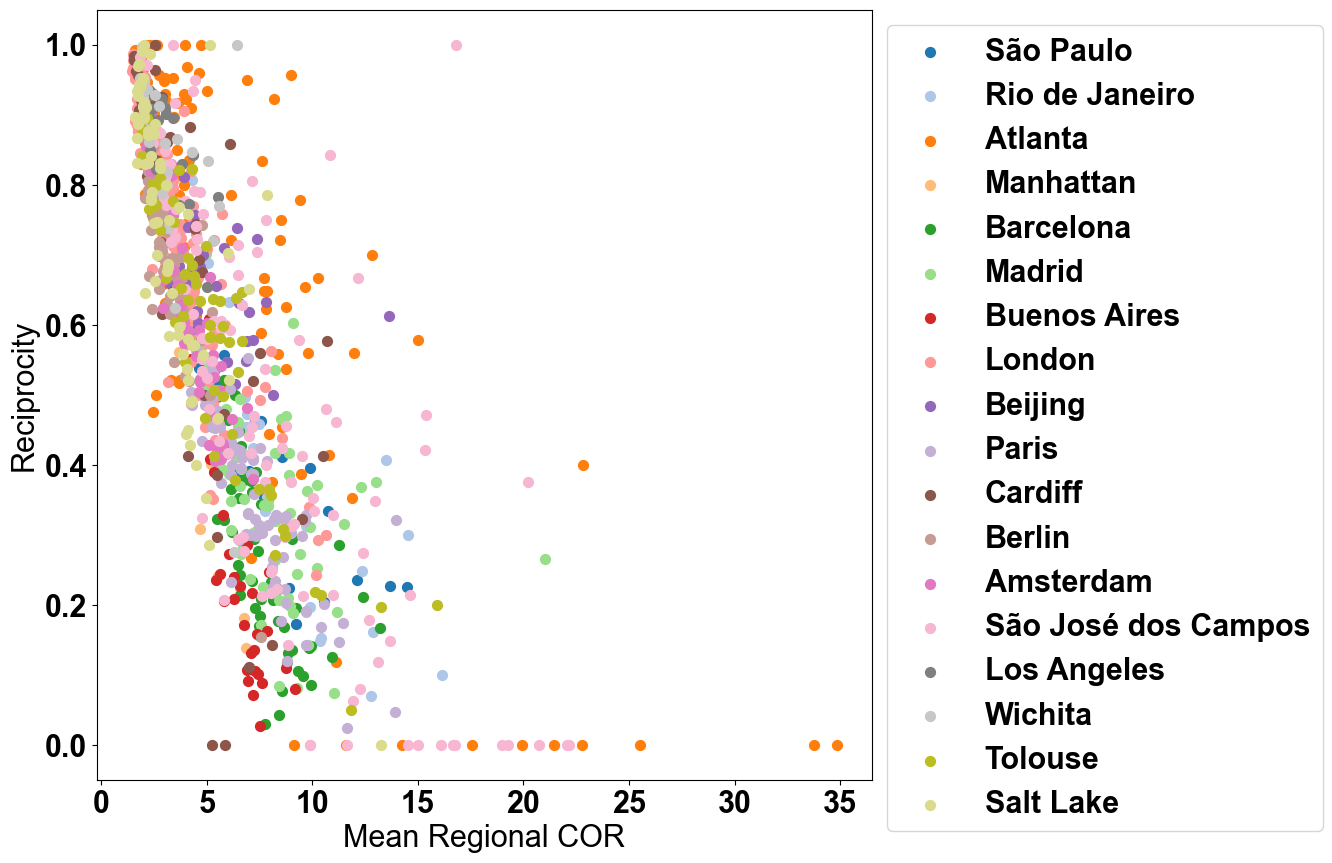

In [ ]:
plt.figure(figsize=(10,10))

popt, pcov = curve_fit(func, np.hstack(all_mreg_COR), np.hstack(all_recs), bounds=(0, [3., 1., 0.5]))
print(get_rsq(func, np.hstack(all_mreg_COR), np.hstack(all_recs), popt))
plt.ylabel("Reciprocity")
xdata = np.sort(np.hstack(all_mreg_COR))
ydata =  func(xdata, *popt)
plt.xlabel("Mean Regional COR")
colors = cycle(cm.tab20.colors)
for i in range(len(city_list_full)):
    # plot one cluster for each iteration
    # find indeces corresponding to cluser i
    # idx = kmeans.labels_ == i
    # plot cluster
    color = next(colors)
    plt.scatter(all_mreg_COR[i], all_recs[i], color=color, s=50, label=i, alpha=1)
    # plot center

plt.legend(labels = city_list_full, bbox_to_anchor=(1, 1))
# plt.plot(xdata, ydata, 'k--')
# plt.yscale("log")
plt.savefig("Results/all_together/all_recis.pdf", bbox_inches = "tight")
plt.show()

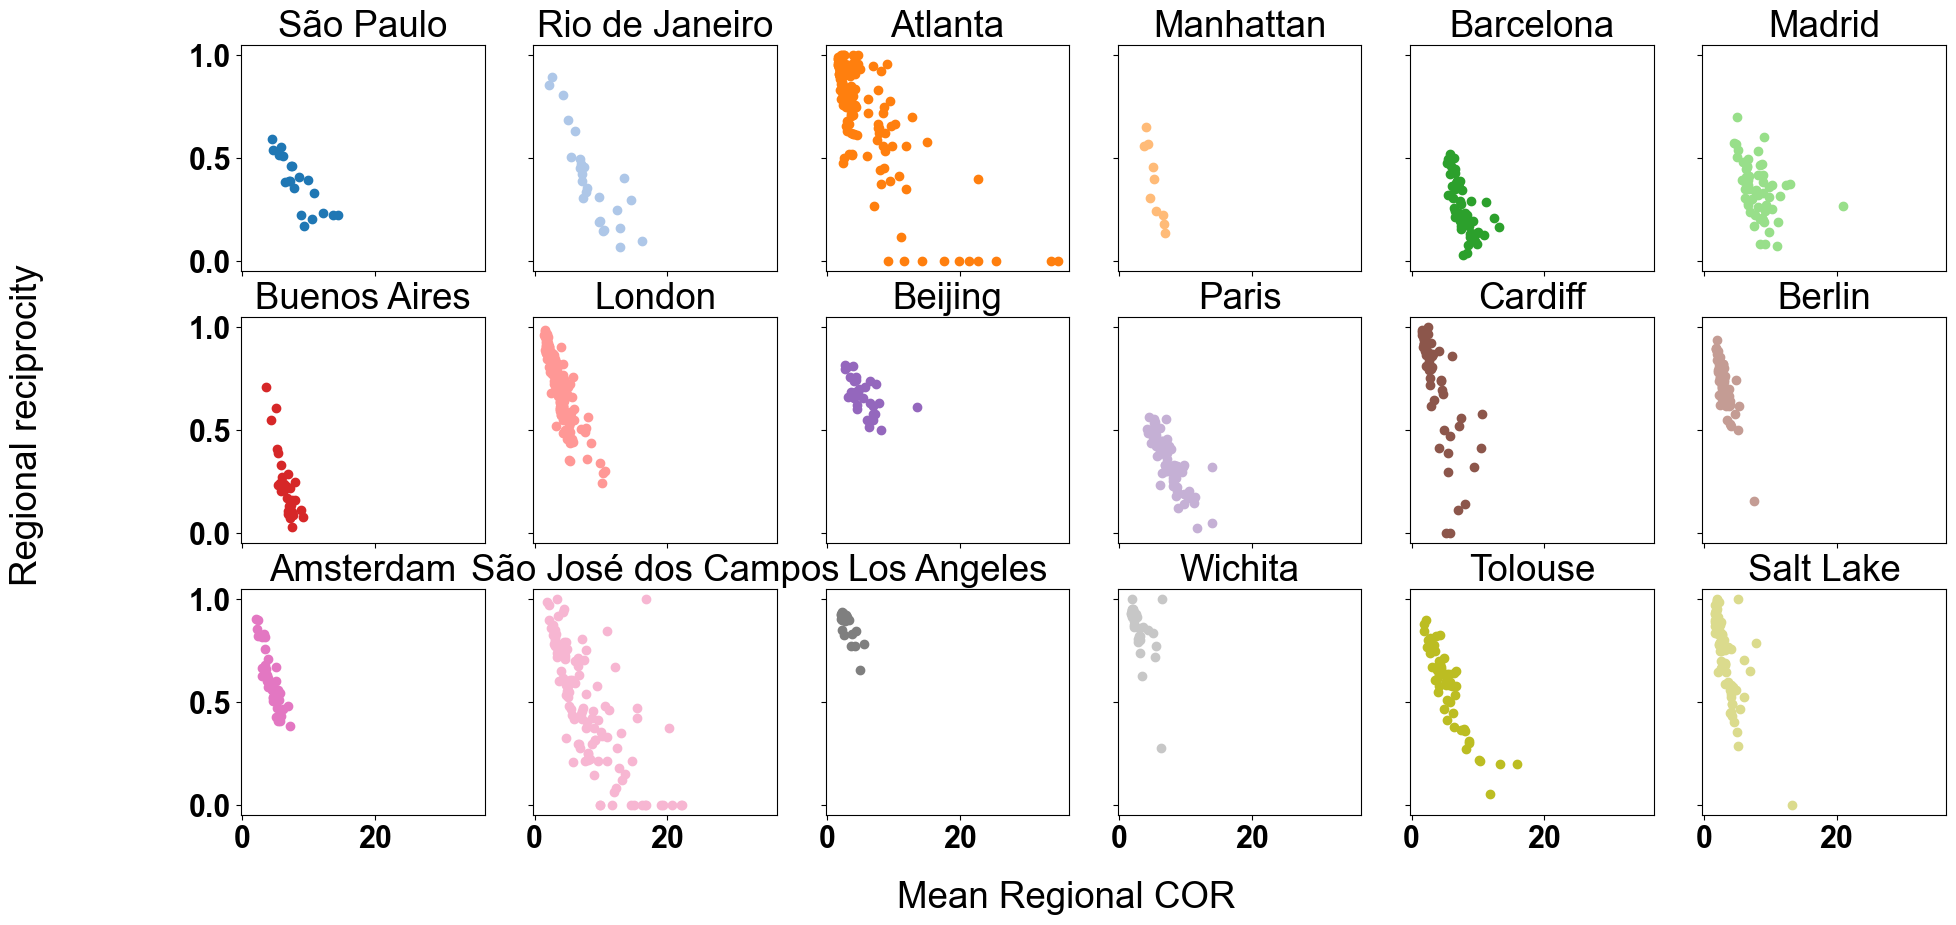

In [ ]:
colors = cycle(cm.tab20.colors)
fits = []
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(22,10), sharex = True, sharey = True)

# for i in range(len(city_list_full)):
#     # plot one cluster for each iteration
#     color = next(colors)
#     plt.title("All Together")
#     # find indeces corresponding to cluser i
#     # idx = kmeans.labels_ == i
#     # plot cluster
#     axis = axs[-1][-1]
#     axis.plot(all_mreg_COR[i], all_recs[i], 'o', color=color, label=i, alpha=1)
fig.supxlabel('Mean Regional COR')
fig.supylabel("Regional reciprocity")
# axs[-1][-1].legend(labels = city_list_full, bbox_to_anchor=(1, 3.5))
# popt, pcov = curve_fit(func, np.hstack(all_mreg_COR), np.hstack(all_recs), bounds=(0, [3., 1., 0.5]))
# xdata = np.sort(np.hstack(all_mreg_COR))
# ydata =  func(xdata, *popt)
# axis.plot(xdata, ydata, '--', color = 'k', label = False)

colors = cycle(cm.tab20.colors)
for i in range(len(city_list_full)):
    # plot one cluster for each iteration
    color = next(colors)
    # find indeces corresponding to cluser i
    # idx = kmeans.labels_ == i
    # plot cluster
    axis = axs[i//6][i%6]
    # popt, pcov = curve_fit(func, all_mreg_COR[i], all_recs[i], bounds=(0, [3., 1., 0.5]))
    fits.append(popt)
    xdata = np.sort(all_mreg_COR[i])
    ydata =  func(xdata, *popt)
    # axis.plot(xdata, ydata, color = color)
    axis.set_title(city_list_full[i])
    axis.plot(all_mreg_COR[i], all_recs[i], 'o', color=color, label=i, alpha=1)

    # plot center


fig.savefig("Results/all_together/all_recis_separated.pdf", bbox_inches='tight')
plt.show()

## WCCs

In [48]:
dfs = pd.DataFrame()
types = ["COR", "CoR w/o Com", "Betwenness", "Random"]
_elist = []
_type = []
_percent = []
kk = 0
for i in percents:
    # _elist = []
    for dframes in [all_wccs_COR_high.T, all_wccs_SP.T, all_wccs_bet_high.T, all_wccs_random.T]:
        _elist = _elist + list(dframes[i])
        _percent += [i]*len(dframes)
        _type += [types[kk%4]]*len(dframes)
        kk+=1
dfs['Value'] = _elist
dfs["Percent"] = _percent
dfs["Type"] = _type


fig = go.Figure()

for tipo in types:
    fig.add_trace(go.Box(x=dfs['Percent'][dfs['Type'] == tipo]*100,
                            y=dfs['Value'][dfs['Type'] == tipo],
                            name=tipo,
                            # box_visible=True,
                            # meanline_visible=True, spanmode='hard'
                            ))

fig.update_layout(
    # title="Plot Title",
    xaxis_title="Percent of edges removed",
    yaxis_title="Normalized WCC size",
    legend_title="Induced by",  
    font=dict(
        family="Computer Modern Roman",
        size=18,
        color="Black"
    ),
    xaxis = dict(
        tickmode = 'array',
        tickvals = percents*100,
    ),
    # violinmode='group',
    boxmode = 'group',
    # violingap=0.001,
    width = 1960/2,
    height = 1080/2,
    margin=dict(l=20, r=20, t=5, b=20),
)

fig.show()
# fig.write_image("Results/WCCs.pdf")

In [4]:
all_wccs_SP.iloc[0].sort_values()

Series([], Name: 0.01, dtype: float64)

Fazer um ajuste de lei de potência

Adicionar cidades

Fazer análise teórica das equações